# ConditionalWaveNet

## Preparations

In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
%cd /content/drive/My\ Drive/Project-X/colab/src

/content/drive/My Drive/Project-X/colab/src


In [3]:
! git clone https://github.com/Studienarbeit-Konrad-Hendrik/ConditionalWaveNetModel.git .

fatal: destination path '.' already exists and is not an empty directory.


## Actual Code

### Data Preparation

In [4]:
import torch
import numpy as np
import imp
import Helpers.data as d


In [5]:
data_x = d.get_data(10240, 8, 128)

3822.8619140625
2424.81630859375


In [6]:
data_x[0].shape

(10240, 8, 1)

In [7]:
sample_size = 10240

prepared_data_x = []
prepared_data_y = []
for d in data_x:
  d_rs = d.reshape((d.shape[0], d.shape[1]))
  d_reorged = np.einsum("ij->ji", d_rs)
  d_expanded = np.expand_dims(d_reorged, axis=(1,))

  d_splitted = np.split(d_expanded, d_expanded.shape[2] // sample_size, axis=2)
  
  prepared_data_x += d_splitted

  for ds in d_splitted:
    y = np.copy(ds)
    y = np.concatenate([y[:,:,1:], np.zeros((y.shape[0], y.shape[1], 1))], axis=2)
    prepared_data_y.append(y)


In [8]:
print(data_x[0].shape)

(10240, 8, 1)


Scale down from 16bit PCM

In [9]:
scaled_data_y = []
scaled_data_x = []


for b in range(len(prepared_data_x)):
  scaled_data_y.append(torch.from_numpy(prepared_data_y[b] / abs(prepared_data_y[b]).max()).float())
  scaled_data_x.append(torch.from_numpy(prepared_data_x[b] / abs(prepared_data_x[b]).max()).float())



In [10]:
def mu_transform(data_in, mu=255):
  in_bounds = torch.sign(data_in) * (torch.log(mu * torch.abs(data_in) + 1) / torch.log(torch.tensor(1 + mu, dtype=torch.float)))
  return (in_bounds * (((mu + 1) // 2) - 1) + 128).long()


In [11]:
def mu_transform_inverted(data_in, mu=255):
  data_scaled = (data_in - 128) / ((mu + 1) // 2 - 1)
  return torch.sign(data_scaled) * torch.tensor(1 / mu) * (torch.pow(torch.tensor(1 + mu, dtype=torch.float), torch.abs(data_scaled)) - 1)

In [12]:
mu_transformed_y = []
mu_transformed_x = []
for b in range(len(prepared_data_x)):
  mu_transformed_y.append(mu_transform(scaled_data_y[b]).reshape((scaled_data_y[b].shape[0], scaled_data_y[b].shape[2])))
  mu_transformed_x.append(mu_transform(scaled_data_x[b]).reshape((scaled_data_y[b].shape[0], scaled_data_y[b].shape[2])))

In [13]:
import torch.nn.functional as fun

In [14]:
print(mu_transformed_y[0].shape)

torch.Size([8, 10240])


In [15]:
import matplotlib.pyplot as plt

### Model loading and initialization

In [16]:
import ConditionalWaveNetModel as cw
import imp
imp.reload(cw)

<module 'ConditionalWaveNetModel' from '/content/drive/My Drive/Project-X/colab/src/ConditionalWaveNetModel.py'>

In [17]:
import Encoder as enc
imp.reload(enc)

<module 'Encoder' from '/content/drive/My Drive/Project-X/colab/src/Encoder.py'>

In [18]:
import Upsampler as ups
imp.reload(ups)

<module 'Upsampler' from '/content/drive/My Drive/Project-X/colab/src/Upsampler.py'>

In [19]:
device = torch.device("cuda")
model = cw.ConditionalWaveNet(has_local_cond=True, has_global_cond=False, num_dilated_layers=9, dialated_filter_nums=[32, 32, 32, 32, 32, 32, 32, 32, 32], input_channels=1).to(device)

In [20]:
downsampler = enc.Downsampler(kernel_size=32, num_conv_layers=5).to(device)

In [21]:
upsampler = ups.Upsampler(kernel_size=32, layers=5).to(device)

### Training

In [22]:
def accuracy(predicted, target):
  _, pred_pos = torch.max(predicted, dim=1)
  result = torch.sum(torch.eq(target, pred_pos) * 1.0, dim=1) / target.shape[1] 
  
  mean_val = torch.mean(result)

  return mean_val


In [23]:
def mean_dist(predicted, target):
  _, pred_pos = torch.max(predicted, dim=1)
  result = torch.mean(torch.abs(target - pred_pos).float())
  return result

In [24]:
import torch.nn as nn
import torch.optim as optim

In [26]:
epochs = 2000
loss_f = nn.NLLLoss()
optimizer = optim.Adam(list(model.parameters()) + list(downsampler.parameters()) + list(upsampler.parameters()), lr=0.001)

In [27]:
for e in range(epochs):
  avg_loss = 0.0
  avg_accuracy = 0.0
  avg_distance = 0.0
  for b in range(len(scaled_data_x)):
    x_data = scaled_data_x[b].float().cuda()
    y_data = mu_transformed_y[b].cuda()

    optimizer.zero_grad()

    encoded = downsampler(x_data)
    upsampled = upsampler(encoded)

    # print(upsampled.shape)

    out_data, skip_sum = model.foot(x_data, y=upsampled)
    pred_data = model.head(skip_sum)

    loss = loss_f(pred_data, y_data)
    loss.backward()

    optimizer.step()

    avg_loss += loss
    avg_accuracy += accuracy(pred_data, y_data)
    avg_distance += mean_dist(pred_data, y_data)
  avg_loss /= len(scaled_data_x)
  avg_distance /= len(scaled_data_x)
  avg_accuracy /= len(scaled_data_x)

  print(e, avg_loss, avg_accuracy, avg_distance)

0 tensor(4.2246, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0974, device='cuda:0') tensor(26.4671, device='cuda:0')
1 tensor(3.4264, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.1574, device='cuda:0') tensor(11.8550, device='cuda:0')
2 tensor(3.2714, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.1743, device='cuda:0') tensor(11.2183, device='cuda:0')
3 tensor(3.0698, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.2092, device='cuda:0') tensor(10.2482, device='cuda:0')
4 tensor(2.9542, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.2183, device='cuda:0') tensor(9.8494, device='cuda:0')
5 tensor(2.9598, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.2190, device='cuda:0') tensor(10.3950, device='cuda:0')
6 tensor(2.9054, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.2321, device='cuda:0') tensor(10.6045, device='cuda:0')
7 tensor(2.7853, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.2393, device='cuda:0') tensor(9.7161, device='cuda:0')
8 tensor(2.7266, d

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

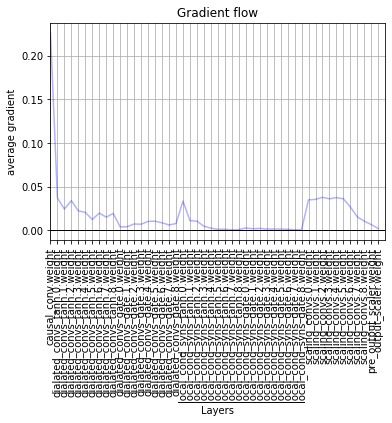

In [ ]:
plot_grad_flow(model.named_parameters())

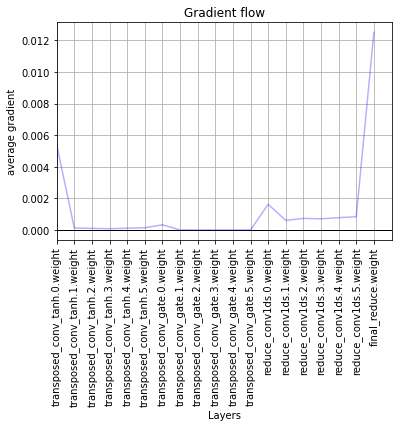

In [ ]:
plot_grad_flow(upsampler.named_parameters())

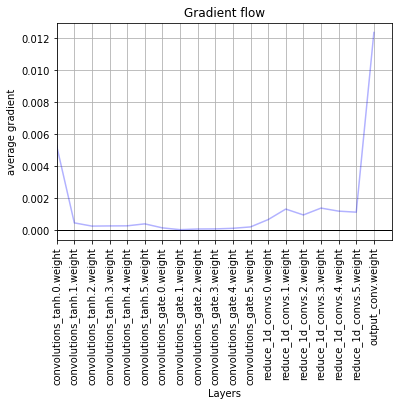

In [ ]:
plot_grad_flow(downsampler.named_parameters())

In [ ]:
print(encoded)

tensor([[[ 3.1843e+00,  2.1936e+00,  8.3542e-01,  1.2682e+00,  1.8455e+00,
           1.7855e+00,  1.7324e+00,  1.7565e+00,  1.8647e+00,  8.5704e-01,
           1.2794e+00,  2.8664e+00,  2.7305e+00,  5.0166e+00,  6.9979e+00,
           8.2488e+00,  9.8025e+00,  1.0043e+01,  8.6919e+00,  1.0501e+01,
           1.0941e+01,  1.0368e+01,  1.0257e+01,  1.0029e+01,  8.3570e+00,
           6.5491e+00,  3.8837e+00,  2.6260e+00,  8.9389e-01,  6.9274e-01,
           1.2170e+00,  1.1831e+00,  1.1438e+00, -2.9834e-01, -4.8385e-01,
           8.5852e-01,  9.8514e-01,  8.8220e-02,  2.0874e-01,  9.7576e-01,
           1.1213e+00,  1.0355e+00,  9.9292e-01,  9.1463e-01,  1.6666e+00,
           1.5975e+00,  1.5343e+00,  1.4025e+00,  1.8668e+00,  1.6977e+00,
           1.9353e+00,  2.0085e+00,  2.0076e+00,  1.8339e+00,  1.8395e+00,
           1.7363e+00,  1.4792e+00,  1.3643e+00,  2.2605e+00,  2.1175e+00,
           3.0988e+00,  4.7655e+00,  5.4645e+00,  7.8205e+00,  6.7342e+00,
           7.9691e+00,  9

In [ ]:
_, pos = torch.max(pred_data, dim=1)

current rate: 375 tensor(1.5701, device='cuda:0', grad_fn=<DivBackward0>)

In [ ]:
windy_data[:,0]

In [ ]:
pred_data[:,:,0]

In [ ]:
pos

tensor([[97]], device='cuda:0')

In [ ]:
len(list(model.parameters()))

32

In [ ]:
import torchsummary

In [ ]:
torchsummary.summary(model, [(1, 5000), (1,5000)], batch_size=16)

In [ ]:
! pip install hiddenlayer

In [ ]:
import hiddenlayer

In [ ]:
g = hiddenlayer.build_graph(model, torch.zeros([16, 1, 5000]).cuda())
g

NameError: ignored

In [ ]:
g.save("network_graph.svg")

In [ ]:
!git config --global user.email "hendrik.leier75@gmail.com"
!git config --global user.name "Hendrik Leier"

In [ ]:
!git commit -m "First running example on WaveNet"

[master 3211e19] First running example on WaveNet
 2 files changed, 1 insertion(+), 2 deletions(-)
 rewrite WaveCnn.ipynb (96%)


In [ ]:
!git push

Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 5.58 KiB | 953.00 KiB/s, done.
Total 4 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/Studienarbeit-Konrad-Hendrik/ConditionalWaveNetModel.git
   d7b9403..3211e19  master -> master


In [ ]:
! git submodule add https://github.com/Studienarbeit-Konrad-Hendrik/Helpers.git

Cloning into '/content/drive/My Drive/Project-X/colab/src/Helpers'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 7 (delta 0), reused 7 (delta 0), pack-reused 0
Unpacking objects: 100% (7/7), done.


In [ ]:
downsampler = enc.Downsampler(kernel_size=32)

In [ ]:
downsampler.forward(torch.ones((16, 1, 12345))).shape

torch.Size([16, 1, 48])

In [ ]:
torchsummary.summary(downsampler, [(1, 12345)], batch_size=16)

In [ ]:
g = hiddenlayer.build_graph(downsampler, torch.zeros([16, 1, 12345]))
g

In [ ]:
upsampler = ups.Upsampler(kernel_size=16)

In [ ]:
upsampler.forward(torch.ones((16, 1, 48))).shape

torch.Size([16, 1, 12288])

/usr/local/lib/python3.6/dist-packages/torch/onnx/symbolic_helper.py:267: UserWarning: You are trying to export the model with onnx:Upsample for ONNX opset version 9. This operator might cause results to not match the expected results by PyTorch.
ONNX's Upsample/Resize operator did not match Pytorch's Interpolation until opset 11. Attributes to determine how to transform the input were added in onnx:Resize in opset 11 to support Pytorch's behavior (like coordinate_transformation_mode and nearest_mode).
We recommend using opset 11 and above for models using this operator. 
  "" + str(_export_onnx_opset_version) + ". "


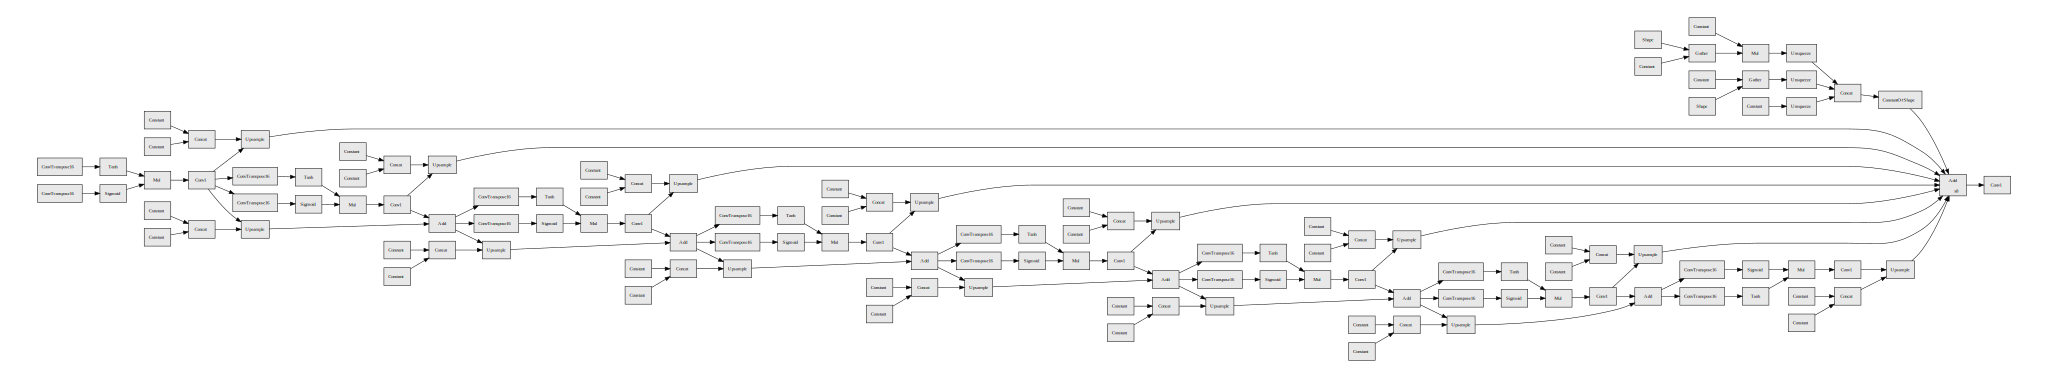

In [ ]:
g = hiddenlayer.build_graph(upsampler, torch.zeros([16, 1, 48]))
g

In [29]:
! git add Encoder*

On branch master
Your branch is up to date with 'origin/master'.

Changes to be committed:
  (use "git reset HEAD <file>..." to unstage)

	new file:   .gitmodules
	new file:   Helpers

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)
  (commit or discard the untracked or modified content in submodules)

	modified:   ConditionalWaveNetModel.py
	modified:   Helpers (modified content, untracked content)
	modified:   WaveCnn.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	Encoder.py
	Upsampler.py
	__pycache__/
	credentials/
	metrics.py

